# Homework 1

## Physics 7810
## Due January 27, 2020

## H1.1 - Ordinary differential equation (ODE) solvers

In the first tutorial, you solved the equations of motion for the 1D simple harmonic oscillator (SHO) using various simple integration algorithms (Euler, symplectic Euler, and velocity Verlet). This is an example of an *initial value problem*. A number of sophisticated, general-purpose ODE solvers exist to solve such problems, based on algorithms such as the Runge-Kutta and predictor-corrector methods, with enhancements such as variable step size and Richardson extrapolation to control and maintain accuracy.

While symplectic integrators such as velocity Verlet are well-suited for Hamiltonian systems (where the energy is conserved), these more general ODE solvers are typically the methods of choice for solving systems of differential equations where there is no conserved energy or Hamiltonian.

Revisit the 1D SHO, and solve the equations of motion using one of these general purpose methods (the widely used implicit Runge-Kutta method of order 5(4) (RK45) might be a good choice). A number of ODE solvers (including RK45) are available in the `scipy.integrate` library, which can be imported using `import scipy.integrate as integrate`.

As a reminder, Hamilton's equations of motion for the 1D SHO are:

$$\dot{X} = \frac{\partial \cal{H}}{\partial P} = P$$

$$\dot{P} = - \frac{\partial \cal{H}}{\partial X} = - X,$$

Write a python program to integrate these equations of motion using RK45 (`scipy.integrate.RK45`) and compare the results with those obtained using the velocity Verlet algorithm on both short timescales (a few periods of oscillation) and very long timescales (thousands of periods of oscillation), e.g., by making phase space plots and energy plots. Is the RK45 algorithm stable, or does the energy drift over long timescales? Compare the relative short-time accuracies of RK45 and velocity Verlet by measuring the amplitude (standard deviation) of energy fluctuations about the exact value ($E = 1$).

### Solution
To improve the flexibility of the code, in the folder `CompPhysLib`, I wrote a Python library `SHO_integrators.py` for solving problems in Tutorial_01 and Homework_01 here, which can be imported as below.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, '../')
from CompPhysLib.SHO_integrators import SHO_integrators
from scipy.integrate import solve_ivp
from numpy.linalg import norm

#### Part 1 of H1.1: Comparison of RK45 scheme with Verlet algorithm on a short timescale ($20 \pi$)

The standard deviations of Verlet and RK45 algorithm are 0.015270101860639701 and 0.0005413788307580755, respectively.


<Figure size 432x288 with 0 Axes>

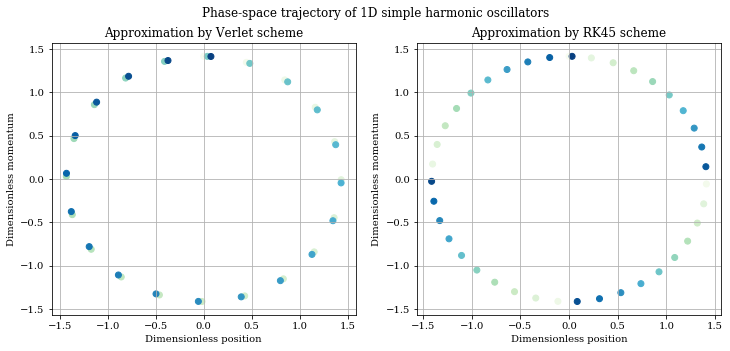

<Figure size 432x288 with 0 Axes>

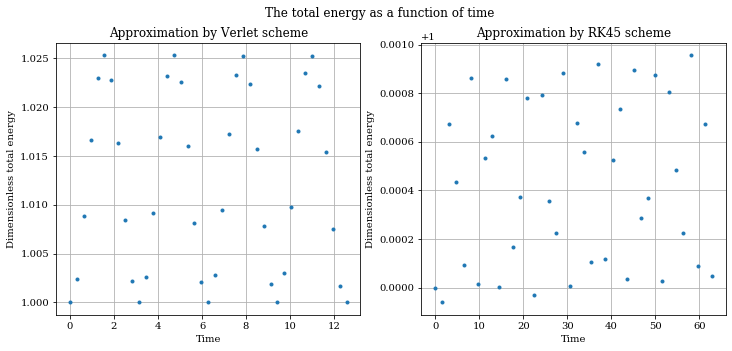

In [2]:
def SHO(t, z):
    x, p = z          # z: vector of the state variable
    return [p, -x]    # dx/dt = p, dp/dx = -x

def RK45_Verlet(t_final):
    n = int(t_final / (0.5 * np.pi))   # number of data pionts
    t = np.linspace(0, t_final, n)     # range of time to integrate
    x_0, p_0 = 0, np.sqrt(2)

    # solve_ivp(func, t_span, y0, ...)
    sol = solve_ivp(SHO, [0, t_final], [x_0, p_0], dense_output=True)
    z = sol.sol(t)   # x(t) = z[0], p(t) = z[1]
    x_rk45, p_rk45 = z[0], z[1]

    # RK45
    SI = SHO_integrators()
    RK45 = SI.integrators(integrator='RK45', dt=t[-1] - t[-2], n=len(t))
    RK45.x_approx, RK45.p_approx = z[0], z[1]
    RK45.E = 0.5 * np.power(RK45.x_approx, 2) + 0.5 * np.power(RK45.p_approx, 2)
    RK45.RMSD = np.sqrt((1/len(RK45.E) * np.sum(np.power(RK45.E - 1, 2))))

    # Verlet
    SI = SHO_integrators()
    verlet = SI.integrators(integrator='Verlet', n=n, dt=0.1*np.pi)

    SI.SHO_plots_compare(verlet, RK45, False)
    
    print('The standard deviations of Verlet and RK45 algorithm are %s and %s, respectively.' %(verlet.RMSD, RK45.RMSD))

RK45_Verlet(20 * np.pi)

As shown above, in terms of the phase-space trajectory, both algorithms provide a good estimation. On the other hand, RK45 scheme obviously has a smaller uncertainty compared to Verlet scheme, with a standard deviation in the total energy as $0.00054$, which is much smaller than the one of Verlet scheme ($0.1527$). Therefore, for a short timescale, RK45 scheme is more robust than Verlet scheme.

#### Part 2 of H1.1: Comparison of RK45 scheme with Verlet algorithm on a long timescale ($5000 \pi$)

The standard deviations of Verlet and RK45 algorithm are 0.01549004402816966 and 0.01886374633889205, respectively.


<Figure size 432x288 with 0 Axes>

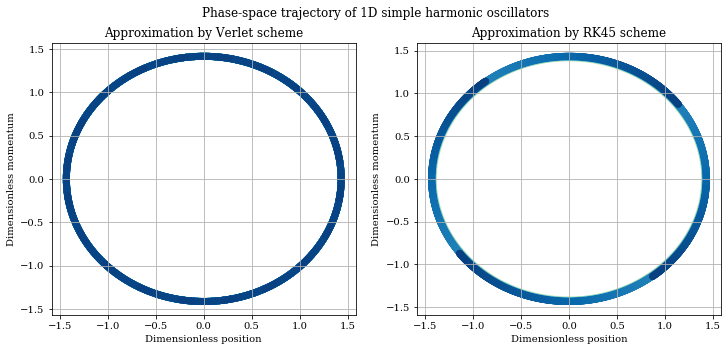

<Figure size 432x288 with 0 Axes>

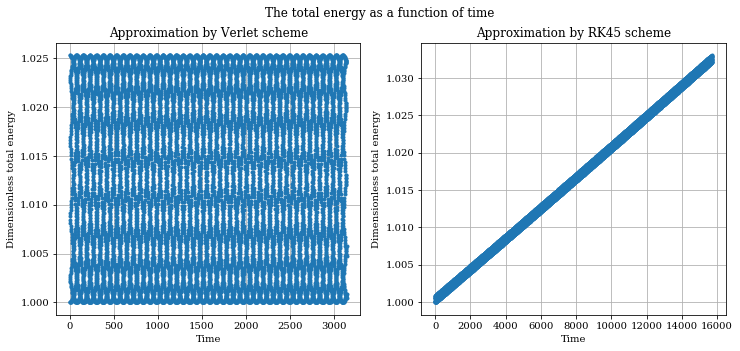

In [3]:
RK45_Verlet(5000 * np.pi)

Unlike the situation given a short timescale, with a long timescale like $5000\pi$, RK45 scheme shows a larger standard deviation than Verlet scheme. As shown in the figure above, the energy estimated by RK45 drift over long timescales (accordingly, the standard deviation in the estimation of the total energy increases with time), which indicates that for a long simulation, Verlet scheme is apparently a better choice than RK45 scheme.

## H1.2 - Motion in a central force potential

Write a python program to simulate the motion of a particle in a central force potential in two dimensions. Take the form of the potential to be

$$
U({\bf r}) = u r^n,
$$

where ${\bf r} = (x,y)$ is the 2D position of the particle, $r = |{\bf r}|$, and $n$ is a positive integer.

First write down the Hamiltonian for this system, and derive Hamilton's equations of motion. Then use the velocity Verlet algorithm to numerically integrate the equations of motion for a few specific cases, say $n = 2$ (2D simple harmonic oscillator) and $n = 4$. Adjust the timestep to ensure good energy conservation, and plot the trajectory of the particle in the $x-y$ plane for various initial conditions. Verify that the particle has the expected elliptical orbit for $n = 2$, and explore how the nature of the orbit changes with varying $n$.

A basic result from classical mechanics is the *virial theorem*, which relates the average kinetic energy $\langle K \rangle$ and the average potential energy $\langle U \rangle$ for a single particle in a central force potential,

$$
\langle K \rangle = \frac{n}{2} \langle U \rangle,
$$

where the angle brackets denote an average over an integral number of periods of the motion, or over a sufficiently long timescale that the averages converge to well-defined values (many periods of motion).

Verify the virial theorem for a few specific values of $n$, by calculating $\langle K \rangle$ and $\langle U \rangle$ from long simulation trajectories.

Repeat these steps for a central force potential of the form

$$
U({\bf r}) = - u r^{-n},
$$

where $n$ is a positive integer. Of particular interest is the case $n = 1$ (gravitational or Coulomb potential).

### Solution

#### Part 1 of H1.2: Hamiltonian's equations of motion
The Hamiltonian for this system is $H(p,r)=\frac{p^{2}}{2m} + ur^{n}$. Accordingly, the Hamiltonian's equations of motion should be
\begin{equation}
\dot{r} = \frac{\partial H}{\partial p} = \frac{p}{m}, \; \dot{p} = - \frac{\partial H}{\partial r} = unr^{n-1}
\end{equation}
For the sake of convenience, here we formulate this problem in dimensionless variables like we did in the class. Specifically, the units of length and momention are $r_{0} = (\frac{E}{u})^{\frac{1}{n}}$ and $p_0=\sqrt{Em}$, respectively. Defining the dimensionless position $R$ and the dimensionless momentum $P$ as below:
\begin{equation}
R = \frac{r}{r_{0}} = r/(\frac{E}{u})^{\frac{1}{n}} \Rightarrow r = R(\frac{E}{u})^{\frac{1}{n}}, \; p = \frac{P}{p_{0}} = p/\sqrt{Em} \Rightarrow P = p\sqrt{Em}
\end{equation}
we can write the Hamiltonian H(p,r) as:
\begin{equation}
E = H(p,r)=\frac{p^{2}}{2m} + ur^{n} = \frac{1}{2}EP^{2} + ER^{2} \Rightarrow {\cal H}(P,R) = H(P,R)/E = \frac{1}{2}P^{2} + R^{n} = 1
\end{equation}
where $E$ is the total energy of the system ($E=H(p,r)$) and ${\cal H}(P,R)$ is the dimensionless Hamiltonian (${\cal H}(P,X) = H(P,X) / E = 1$).
Finally, in terms of dimensionless unit, the Hamiltonian's equation of motion become:
\begin{equation}
\dot{P} = -\frac{\partial {\cal H}}{\partial R} = -n R^{n-1}, \; \dot{R} = \frac{\partial {\cal H}}{\partial P} = P
\end{equation}
Given that $U=ur^{n} \Rightarrow U(x,y) = u (x^{2} + y^{2})^{n/2}$, we can also express these equations in Cartesian coordinates:
$$\dot{x} = \frac{p_{x}}{m}, \; \dot{y} = \frac{p_{y}}{m}$$
where
$$\dot{p_{x}} = -\frac{\partial U(x,y)}{\partial x} = -unx(x^{2} + y^{2})^{\frac{1}{2}n - 1}, \; \dot{p_{y}} = -\frac{\partial U(x,y)}{\partial y} = -uny(x^{2} + y^{2})^{\frac{1}{2}n - 1}$$

#### Part 2 of H1.2: Numerical integration by velocity Verlet algorithm

Given the Hamiltonian's equation of motion above, the velocity Verlet algorithm can be expressed as 
$$ v_x \left(t + \frac{\Delta t}{2} \right) = v_x(t) +  \frac{\Delta t}{2 m} f_x(t) \Rightarrow p_x \left(t + \frac{\Delta t}{2} \right) = p_x \left(t \right) + \frac{1}{2} \Delta t \left( \frac{d p_{x}(t)}{dt} \right) \Rightarrow p_{x} \left( t + \frac{\Delta t}{2} \right) = p_{x}(t) - \frac{1}{2} nux(x^{2} + y^{2})^{\frac{n}{2}-1} \Delta t$$
$$ x(t + \Delta t) = x(t) + \frac{1}{m} p_x \left(t + \frac{\Delta t}{2} \right) \Delta t $$
$$ p_x(t + \Delta t) = p_x \left(t + \frac{\Delta t}{2} \right) - \frac{1}{2} nux(t + \Delta t)(x^{2}(t + \Delta t) + y^{2}(t + \Delta t))^{\frac{n}{2}-1} \Delta t$$

By symmetry, for the y-direction, we have:
$$ p_{y} \left( t + \frac{\Delta t}{2} \right) = p_{y}(t) - \frac{1}{2} nuy(x^{2} + y^{2})^{\frac{n}{2}-1} \Delta t$$
$$y(t + \Delta t) = y(t) + \frac{1}{m} p_y \left(t + \frac{\Delta t}{2} \right) \Delta t $$
$$ p_y(t + \Delta t) = p_y \left(t + \frac{\Delta t}{2} \right) - \frac{1}{2} nuy(t + \Delta t)(x^{2}(t + \Delta t) + y^{2}(t + \Delta t))^{\frac{n}{2}-1}\Delta t$$
Therefore, we can code as below to calculate the total energy or plot the trajectory of the particle in the x-y plane:

In [85]:
def CFP_verlet(n, r0, p0, m=1, u=1, N=10000, dt=0.01, model1=True):
    """
    Parameters
    ----------
    n : int
        The power in the equation of the central force potential.
    r0 : list or np.array
        An array of length of 2 which presents  the initial positions in the x and y directions, respecitvely.
    p0 : list np.array
        An array of length of 2 which presents the initial momenta in the x and y directions, respecitvely.
    m : float
        The mass of the particle. 
    u : float
        The coeffcient in the equation of the central force potential.
    N : int
        The number of steps.
    dt : float
        The timestep used in the numerical integration.
    model1: bool
        Whether Model 1 (U = ur^{n}) is adopted. If not, then Model 2 (U = -ur^{-n}) is adopted.
    """
    if len(r0) != 2 or len(p0) != 2:
        print('Error: The length of the array/list of the initial positions/momenta should be 2!')
        sys.exit()
        
    if model1 is False:
        u = -u
        n = -n
    
    r, p = np.zeros([2, N + 1]), np.zeros([2, N + 1])
    R, P, E, K, U = np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1)
    r[:, 0], p[:, 0] = r0, p0
    R[0], P[0] = norm(r[:, 0]), norm(p[:, 0])
    K[0], U[0] = (1 / (2 * m)) * (P[0] ** 2), u * R[0] ** n
    E[0] = K[0] + U[0]

    for i in range(N):
        p_half = p[:, i] - 0.5 * n * u * r[:, i] * np.power(norm(r[:, i]), n - 2) * dt
        r[:, i + 1] = r[:, i] + (1 / m) * p_half * dt
        p[:, i + 1] = p_half - 0.5 * n * u * r[:, i + 1] * np.power(norm(r[:, i + 1]), n - 2) * dt
        
        R[i + 1], P[i + 1] = norm(r[:, i + 1]), norm(p[:, i + 1])
        K[i + 1] = (1 / (2 * m)) * (P[i + 1] ** 2) 
        U[i + 1] = u * R[i + 1] ** n
        E[i + 1] = K[i + 1] + U[i + 1]
        
    ratio = 2 * np.mean(K) / np.mean(U)
    print('The ratio 2<K>/<U> is %s' % ratio)
    
    # Plotting   
    plt.figure()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    if model1 is True:
        plt.suptitle('Motion in central force potential ($U = ur^{%s}$)' %n)
    else:
        plt.suptitle('Motion in central force potential ($U = -ur^{%s}$)' %n)
    #fig.tight_layout(pad=3.0)

    plt.subplot(1, 2, 1)
    plt.scatter(r[0], r[1], c = plt.cm.GnBu(np.linspace(0, 1, len(r[0]))))
    plt.title('Particle trajectory in x-y plane')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid()
                        
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(E)) * dt, E, '.')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    if max(abs(E)) >= 10000:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.title('Energy as a function of time')
    plt.grid()

##### Case 1: $n=1$ with different initial conditions

As shown below, 

The ratio 2<K>/<U> is 0.9747095169015831


<Figure size 432x288 with 0 Axes>

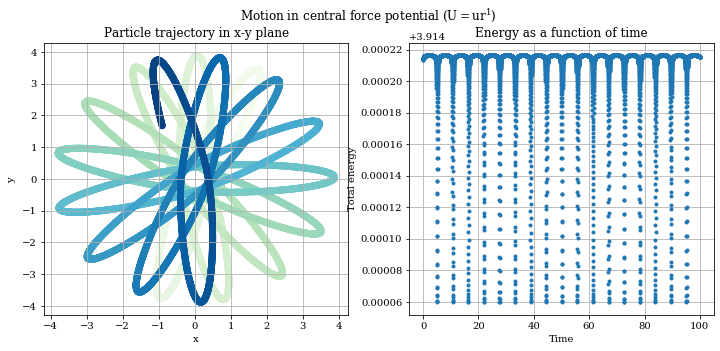

In [96]:
CFP_verlet(1, [1, 1], [1, 2])

The ratio 2<K>/<U> is 0.9747095169015831


<Figure size 432x288 with 0 Axes>

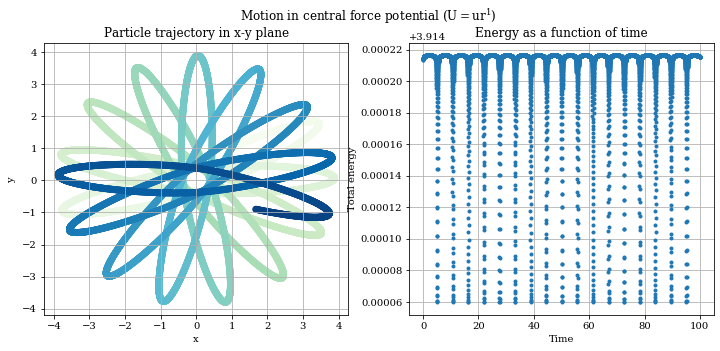

In [97]:
CFP_verlet(1, [1, 1], [2, 1])

The ratio 2<K>/<U> is 0.998652432874707


<Figure size 432x288 with 0 Axes>

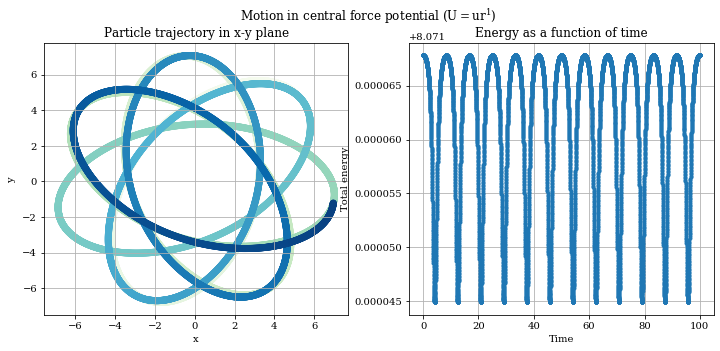

In [98]:
CFP_verlet(1, [5, 5], [-1, 1])

##### Case 2: $n=2$ with different initial conditions

The ratio 2<K>/<U> is 1.9987466462014156


<Figure size 432x288 with 0 Axes>

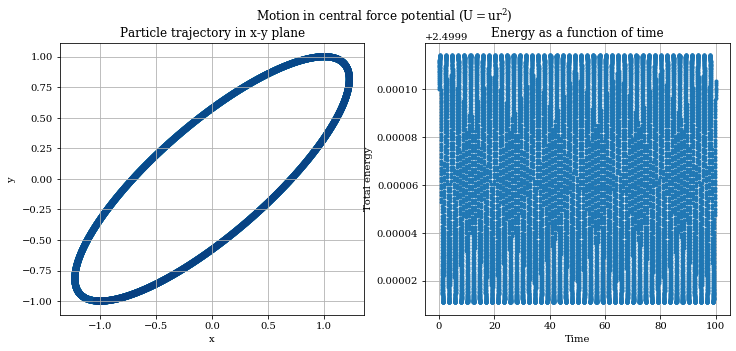

In [99]:
CFP_verlet(2, [1, 1], [1, 0])

##### Case 3: $n=4$ with different initial conditions

The ratio 2<K>/<U> is 4.007671599937494


<Figure size 432x288 with 0 Axes>

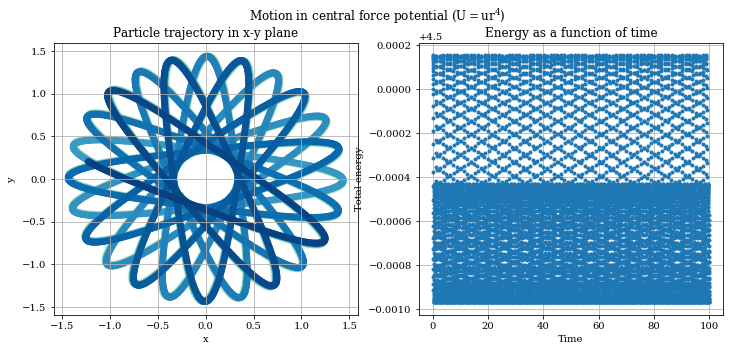

In [100]:
CFP_verlet(4, [1, 1], [1, 0])

#### Part 3 of H1.2: Another case: $U = -un^{-r}$

The ratio 2<K>/<U> is -15.220571540738328


<Figure size 432x288 with 0 Axes>

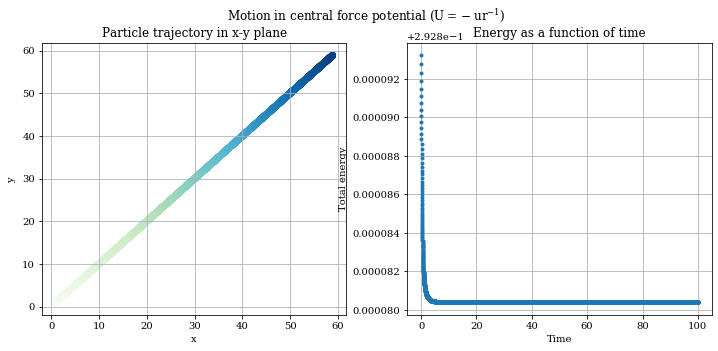

In [101]:
CFP_verlet(1, [1, 1], [1, 1], model1=False)

The ratio 2<K>/<U> is -94007.74360266402


<Figure size 432x288 with 0 Axes>

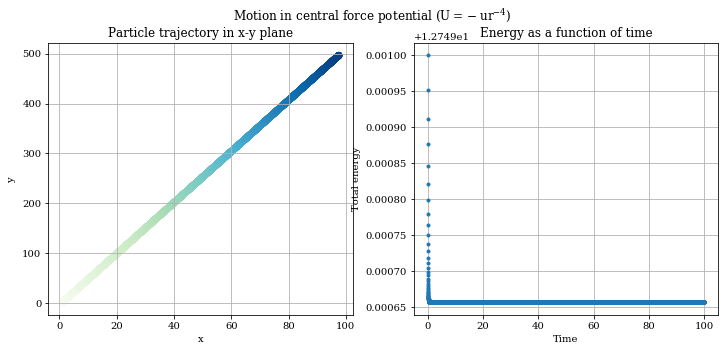

In [102]:
CFP_verlet(4, [1, 1], [1, 5], model1=False)

#### Part 4: of H1.2: Verification of Virial Theorem

#### Problem 2 of H1.2: Numerical integration by velocity Verlet algorithm ($n=2$)


Given the Hamiltonian's equation of motion above, the velocity Verlet algorithm can be expressed as 
$${\bf v}_i \left(t + \frac{\Delta t}{2} \right) = {\bf v}_i(t) +  \frac{\Delta t}{2 m_i} {\bf f}_i(t) \Rightarrow {\bf p}_i \left(t + \frac{\Delta t}{2} \right) = {\bf p}_i \left(t \right) + \frac{1}{2} \Delta t \left( \frac{d {\bf p}_{i}(t)}{dt} \right) \Rightarrow P \left( t + \frac{\Delta t}{2} \right) = P(t) - \frac{\Delta t}{2} n R^{n-1}(t)$$
$${\bf r}_i(t + \Delta t) = {\bf r}_i(t) + {\bf v}_i \left(t + \frac{\Delta t}{2} \right) \Delta t \Rightarrow R(t+\Delta t) = R(t) + P \left( t + \frac{\Delta t}{2} \right) \Delta t$$
$${\bf v}_i(t + \Delta t) = {\bf v}_i \left(t + \frac{\Delta t}{2} \right) + \frac{\Delta t}{2 m_i} {\bf f}_i(t + \Delta t) \Rightarrow P \left( t + \Delta t \right) = P \left(t + \frac{\Delta t}{2} \right) - \frac{\Delta t}{2} n R^{n-1} \left(t + \Delta t \right)$$

For $n=2$, we have:
$$P \left( t + \frac{\Delta t}{2} \right) = P(t) - R(t) \Delta t$$
$$R(t+\Delta t) = R(t) + P \left( t + \frac{\Delta t}{2} \right) \Delta t$$
$$P \left( t + \Delta t \right) = P \left(t + \frac{\Delta t}{2} \right) - R \left(t + \Delta t \right) \Delta t$$

<Figure size 432x288 with 0 Axes>

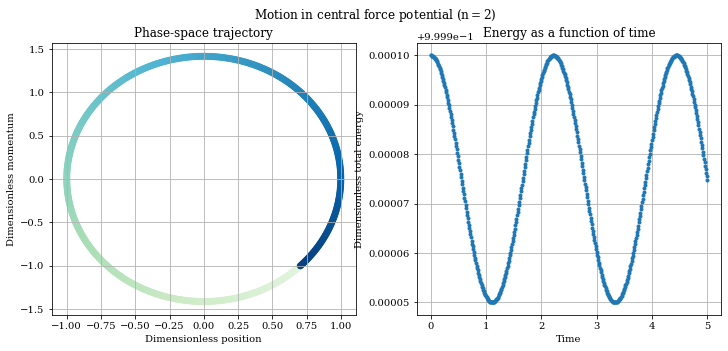

In [11]:
def central_f_verlet(n, N=500, dt=0.01):
    r_0, p_0 = 1, 0
    r_approx, p_approx = [r_0], [p_0]
    for i in range(N):   # N: number of steps
        p_half = p_approx[-1] - 0.5 * (dt) * n * (r_approx[-1]) ** (n - 1)
        r_approx.append(r_approx[-1] + p_half * dt)
        p_approx.append(p_half - 0.5 * dt * n * (r_approx[-1]) ** (n - 1))
                        
    E_approx = np.power(r_approx, n) + 0.5 * np.power(p_approx, 2)     

    plt.figure()
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Motion in central force potential ($n=%s$)' %n)

    plt.subplot(1, 2, 1)
    plt.scatter(r_approx, p_approx, c = plt.cm.GnBu(np.linspace(0, 1, len(r_approx))))
    plt.title('Phase-space trajectory')
    plt.xlabel('Dimensionless position')
    plt.ylabel('Dimensionless momentum')
    plt.grid()
                        
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(E_approx)) * dt, E_approx, '.')
    plt.xlabel('Time')
    plt.ylabel('Dimensionless total energy')
    if max(abs(E_approx)) >= 10000:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.title('Energy as a function of time')
    plt.grid()

central_f_verlet(n=2)